# Project Report: Predicting User Knowledge from Study Habits and Exam Performance

**DSCI 100 009: Group 23** <br>
Allison Fellhauer (38395166) <br>
Agastya Kaul (78851433) <br>
Grace Li (27986504) <br>
Xiangyuan Li (57380230) <br>

## Introduction: Data set and background information

### Background Information

#### User Modeling and User Knowledge

User modeling is used to create a representation of a user based on their interactions with the system ([Chignell & Hancock, 1988](https://doi.org/10.1016/B978-0-444-70536-5.50051-8)). This model can be used to personalize and improve a user’s experience  ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). For example, in e-learning, a user model can be used to track a student’s knowledge level to adapt their learning experience ([Al-Tarabily et al. 2018](https://doi.org/10.1109/ACCESS.2018.2847334)) .

In the dataset [User Knowledge Modeling](https://doi.org/10.24432/C5231X), the authors investigate which user interactions should be used to create the best user knowledge model ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). The goal is to dynamically adjust the student’s learning experience by building a model that classifies their knowledge-level ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

### About the data set

**Our data set:** [User Knowledge Modeling](https://doi.org/10.24432/C5231X)

We have chosen to explore the User Knowledge Modeling data set, which is a data set that classifies users' knowledge of a topic (electrical DC machines) ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

There are 258 observations and 6 variables (5 features and 1 target) in the data set.

#### Features (the predictors)
The features are elements of the user model that include two topics:

A) Goal topics (learning objects):
- The degree of time spent studying the material [STG, double]
- The degree of repetition of the material [SCG, double]
- The performance in exams [PEG, double]


B) Prerequisite topics:
- The degree of study time corresponding to the prerequisite objects [STR, double]
- The knowledge level of the prerequisite objects [LPR, double]

#### Target (predicted class)
User knowledge level [UNS, factor]

Categorized into 4 levels:
- very low (beginner)
- low (intermediate)
- middle (expert) 
- high (advanced)

### Our Question

**Can we predict the knowledge level of a user given their study habits and their performance on the exam?**

Our hypothesis is that if a user has high pre-requisite knowledge, good study habits of both pre-requisite and goal topics, and does well on the exam, we can infer that they have a greater knowledge level.

**Methods & Results:**
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend

## Methods and Results

### Loading necessary libraries and reading in the data

In [11]:
#load all the necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("RColorBrewer")
library(RColorBrewer)
install.packages("kknn") 
library("kknn")
install.packages("themis")
library(themis)
install.packages("cowplot")
library(cowplot)

#read data from the web (GitHub raw file)
url <- "https://raw.githubusercontent.com/afellhauer/DSCI_Group_Project/main/data/Data_User_Modeling_Dataset_Hamdi.csv"
knowledge <- read_csv(url)
head(knowledge)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Rows: 258 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


### Make data usable and readable

Looking at the values, the format is tidy. To make the data usable, UNS (user_knowledge) needs to be converted from a character to a factor. To increase readability, we renamed all variables. We [checked for any missing data](https://www.tutorialspoint.com/dealing-with-missing-data-in-r) and [printed the result](https://www.geeksforgeeks.org/printing-output-of-an-r-program/). There are no missing values.

In [2]:
knowledge_mutate <- knowledge |>
    mutate(UNS = as_factor(UNS)) |> #change the class from a chr to a factor
    rename("study_time_goal" = STG, #relabel all variables to understand them better
           "repetition" = SCG,
           "study_time_related" = STR,
           "performance_related" = LPR, 
           "performance_goal" = PEG,
           "user_knowledge" = UNS) 
# |>
#     select(study_time_goal, repetition, performance_goal, user_knowledge)

head(knowledge_mutate)

missing <- sum(is.na(knowledge_mutate)) # check for missing values
print(paste("Number of missing values: ", missing))

study_time_goal,repetition,study_time_related,performance_related,performance_goal,user_knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


[1] "Number of missing values:  0"


### Split the data into training and testing sets

To ensure reproducibility, we set the seed. We used a proportion of 0.75 for the training to testing ratio. We also stratified the data using user_knowledge, which is the class we are trying to predict. 

In [3]:
set.seed(200) #set seed to be reproducible
#create the initial split of the data
#stratify based on user_knowledge
knowledge_split <- initial_split(knowledge_mutate, prop = 0.75, strata = user_knowledge)

#collected the testing and training portions
knowledge_training <- training(knowledge_split)
knowledge_testing <- testing(knowledge_split)

glimpse(knowledge_training) #see that the number of rows is less than the dataset

Rows: 192
Columns: 6
$ study_time_goal     <dbl> 0.080, 0.180, 0.100, 0.090, 0.080, 0.200, 0.130, 0…
$ repetition          <dbl> 0.080, 0.180, 0.100, 0.300, 0.325, 0.450, 0.390, 0…
$ study_time_related  <dbl> 0.100, 0.550, 0.700, 0.680, 0.620, 0.280, 0.850, 0…
$ performance_related <dbl> 0.24, 0.30, 0.15, 0.18, 0.94, 0.31, 0.38, 0.71, 0.…
$ performance_goal    <dbl> 0.90, 0.81, 0.90, 0.85, 0.56, 0.78, 0.77, 0.90, 0.…
$ user_knowledge      <fct> High, High, High, High, High, High, High, High, Hi…


### Summarizing the data

We examined how balanced or unbalanced the data set is. We created a table that summarized the number of counts for each group of the user_knowledge variable. 

The very_low (beginner) knowledge level is not as represented in this data set.

In [4]:
summary_counts <- knowledge_training |>
    group_by(user_knowledge) |> #group based on the class
    summarize(count = n()) #gets the count (number of observations of each)
summary_counts

user_knowledge,count
<fct>,<int>
very_low,20
High,47
Low,59
Middle,66


**Table 1**: Proportion of observations classified as each user knowledge level (very_low, low, high, middle)

We then summarized the means of our predictors for each class.

In [5]:
summary <- knowledge_training |>
    select(user_knowledge, study_time_goal, repetition, performance_goal) |> 
    #select only the class and the predictors
    group_by(user_knowledge) |>
    summarize("mean_study_time" = mean(study_time_goal), "mean_repetition" = mean(repetition),
              "mean_exam_score" = mean(performance_goal)) 
    #get the mean for each predictor for each group
summary

user_knowledge,mean_study_time,mean_repetition,mean_exam_score
<fct>,<dbl>,<dbl>,<dbl>
very_low,0.3172000,0.1787500,0.0985000
High,0.4220000,0.4170426,0.7646809
Low,0.3249831,0.3482542,0.2386949
Middle,0.4147727,0.3676061,0.5430303


**Table 2**: Mean study time and mean exam score for each user knowledge level (very_low, low, middle, high)

### Visualize the data

We visualized the distribution of the different groups according to their counts. Again, this highlights that the data is not completely balanced.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

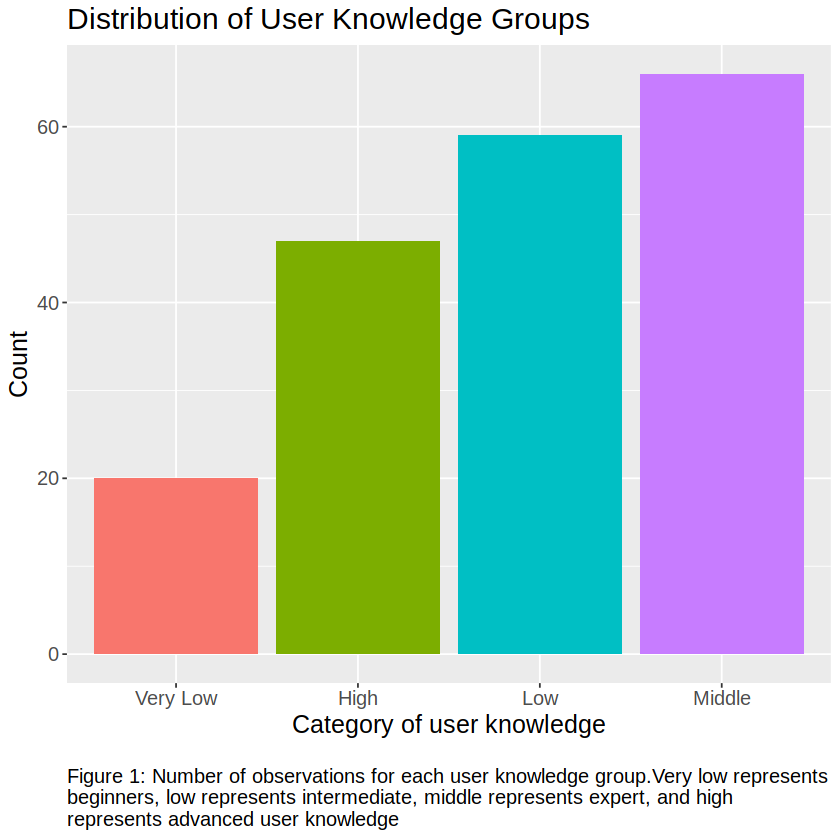

In [6]:
knowledge_training_plot_distribution <- knowledge_training |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
knowledge_training_plot_distribution <- knowledge_training_plot_distribution +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups") +
    labs(caption = "
Figure 1: Number of observations for each user knowledge group.Very low represents 
beginners, low represents intermediate, middle represents expert, and high 
represents advanced user knowledge") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
knowledge_training_plot_distribution

Then, we plotted the data according to study time and exam performance of each of the user knowledge groups. We start to see some distinct groups form.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

In [23]:
knowledge_training_plot_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_goal, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("Goal Object Performance vs Goal Object Study Time")

In [24]:
knowledge_training_plot_repetition_vs_goal <- knowledge_training |>
    ggplot(aes(x = repetition, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of repetition on learning objects (goal)") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("Goal Object Performance vs Goal Object Study Repetition of User Knowledge Groups")

In [25]:
knowledge_training_plot_pre_req_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study on pre-requisite objects") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("Goal Object Performance vs Pre-Requisite Study Time")

In [26]:
knowledge_training_plot_pre_req_performance_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_related, y = performance_related, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance in exans on pre-requisite objects") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("Goal Object Performance vs Pre-Requisite Performance")

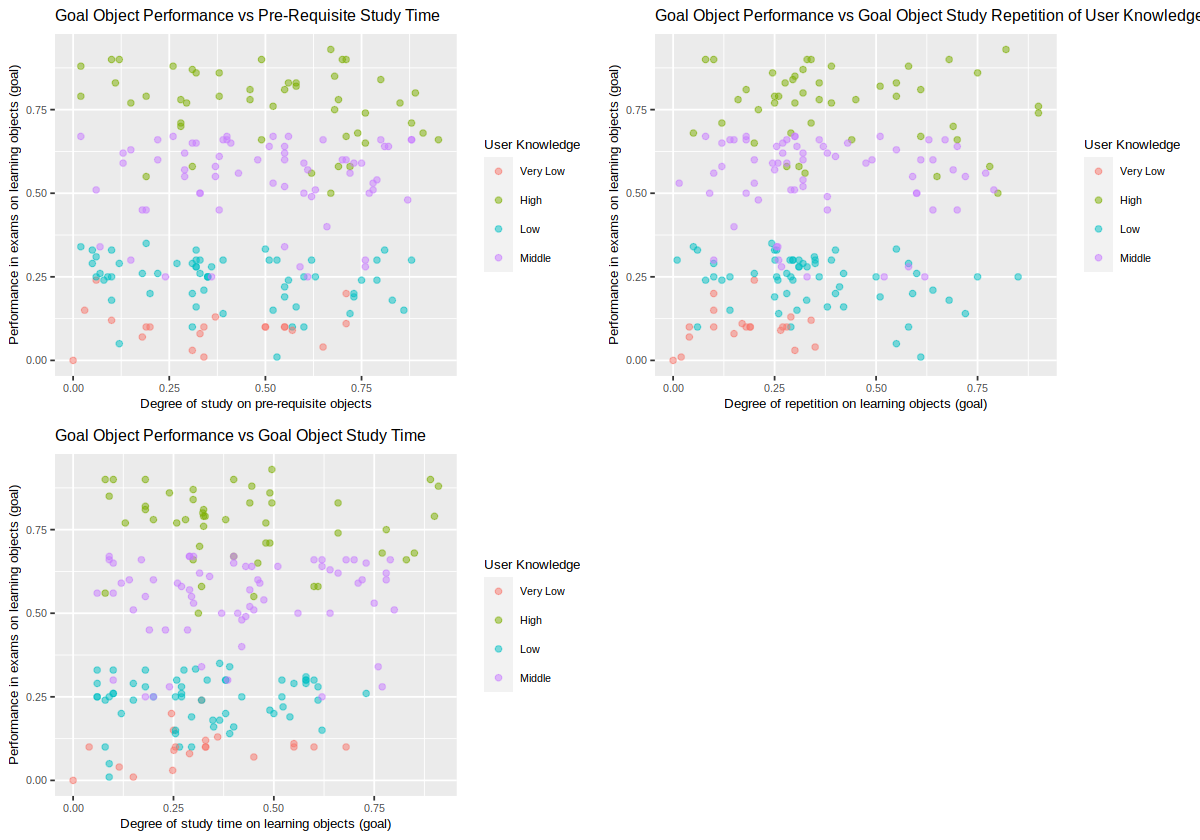

In [28]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot_grid(knowledge_training_plot_pre_req_study_vs_goal, knowledge_training_plot_repetition_vs_goal, knowledge_training_plot_study_vs_goal, ncol = 2)

#### Choosing our predictors
We decided to use all predictors to model the user knowledge. For the goal topics, both time spent studying and degree of repetition contribute to a user's learning. More studying and repetition lead to greater knowledge. Furthermore, a common way to evaluate knowledge in academics is through using tests. Finally, knowledge of pre-requisite knowledge is positively correlated with student achievement (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2630138/)

We classify study habits as the time spent studying and the degree of repetition, which contributes to increased learning. Exam performance is a way to assess learning. 

In [23]:
knowledge_training_plot_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_goal, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("Goal Object Performance vs Goal Object Study Time")

In [ ]:
knowledge_training_plot_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_goal, y = repetition, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Degree of repetition of learning objects (goal)") +
    labs(color = "User Knowledge", 
        caption = "
Figure 2: The perfomance and study time of users according to their learning group.
Very low represents beginners, low represents intermediate, middle represents expert, 
and high represents advanced user knowledge") +
    theme(text = element_text(size = 12), plot.caption = element_text(hjust = 0)) +
    ggtitle("Performance vs Study Time of User Knowledge Groups")
knowledge_training_plot_study_vs_goal

### Analyse the data

As the data is unbalanced (see Fig. 1), we decide to create three models:
- model normal: no balancing
- model upsample: upsample so all ratios are the same as the category with the greatest count (Middle)
- model downsample: downsample so all ratio are the same as the category with the lowest count (Very Low)

#### Model Normal

**Step 1: Create a recipe using all predictors and scale the values**

In [ ]:
knowledge_recipe <- recipe(user_knowledge ~ ., data = knowledge_training) |>
    step_scale(all_predictors())

**Step 2: Tune the model using 5-fold cross-validation**

In [ ]:
# create a knn classification model and set the neighbors to tune()
set.seed(100)
knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
  set_engine("kknn") |>
  set_mode("classification")

# create a sequence of values from 1 to 20
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) 

# split the training data into 5 folds
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = user_knowledge)

# tune the model and collect the accuracy
knowledge_results <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(knowledge_spec) |>
  tune_grid(resamples = knowledge_vfold, grid = k_vals) |>
  collect_metrics() 

# filter the results for accuracies
accuracies <- knowledge_results |>
  filter(.metric == "accuracy")

accuracies

**Step 3: Choose the appropriate K-value for the training set by plotting accuracy for each selection of K**

In [ ]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line(color = "blue") +
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "
    Figure 4: Estimate of accuracy for number of neighbors (K) for values 1-20 using training set.") + 
    theme(text = element_text(size = 14), plot.caption = element_text(hjust = 0)) +
    scale_x_continuous(breaks = 1:20) +
    ggtitle("Estimate of Accuracy vs. Number of Neighbors")

accuracy_vs_k

In [ ]:
k_best <- accuracies |>
    slice_max(order_by = mean, n =1) |>
    select(neighbors) |>
    pull()
k_best

Based on this plot, the best K-value is K = 9.

**Step 4: Create the KNN model using the selected K value**

In [ ]:
know_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) |>
  set_engine("kknn") |>
  set_mode("classification")
know_spec_best

**Step 5: Train the classifier using the training set**

In [ ]:
#Create new workflow using the training set
knowledge_best <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(know_spec_best)|>
    fit(knowledge_training)
knowledge_best

**Step 5: Predict the labels for the unseen testing set**

In [ ]:
#Predicting the testing set
predict_test <- predict(knowledge_best, knowledge_testing) |>
    bind_cols(knowledge_testing)

accuracy_test <- predict_test |> 
    metrics(truth = user_knowledge, estimate = .pred_class)

accuracy_test

In [ ]:
confusion_matrix <- predict_test |> 
      conf_mat(truth = user_knowledge, estimate = .pred_class)
confusion_matrix

#### Model Upsample

**Step 1: Create a balanced dataset by upsampling**

Our approach to balancing the data is to up-sample. We will accomplish this by creating a recipe with step_upsample applied to the user_knowledge variable and then applying "bake()" to produce a new up-sampled training data set. This new data set will be called knowledge_upsample.

In [ ]:
set.seed(59)
# create a recipe to up-sample the current data set using step_upsample()
knowledge_recipe_up <- recipe(user_knowledge ~ ., data = knowledge_training) |>
    step_upsample(user_knowledge, over_ratio = 1, skip = FALSE)

# prep the recipe
knowledge_prep_up <- knowledge_recipe_up |> prep() 

# bake the recipe to apply the changes to the data set
knowledge_upsampled <- bake(knowledge_prep_up, knowledge_training)

# visualize the changes in proportion
upsample_size <- knowledge_upsampled |> nrow()
upsampled_props <- knowledge_upsampled |>
    group_by(user_knowledge) |>
    summarize(distribution_upsampling = n() / upsample_size,
             count_upsampling = n())

knowledge_size <- knowledge_training |> nrow()
knowledge_props <- knowledge_training |>
    group_by(user_knowledge) |>
    summarize(distribution_no_upsampling = n() / knowledge_size, 
             count_no_upsampling = n()) |>
    merge(upsampled_props)
knowledge_props

We then plot the distribution to see if the counts are all the same for Very Low, Low, Medium, and High.

In [ ]:
knowledge_training_plot_distribution_up <- knowledge_upsampled |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
knowledge_training_plot_distribution_up <- knowledge_training_plot_distribution_up +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups (Upsampled)") +
    labs(caption = "
Figure 3: Number of observations for each user knowledge group. Very low represents 
beginners, low represents intermediate, middle represents expert, and high 
represents advanced user knowledge") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
knowledge_training_plot_distribution_up

**Step 2: Create a recipe using all predictors and scale the values**

In [ ]:
knowledge_recipe_upsampled <- recipe(user_knowledge ~ ., data = knowledge_upsampled) |>
    step_scale(all_predictors())

**Step 2: Tune the model using 5-fold cross-validation**

In [ ]:
# create a knn classification model and set the neighbors to tune()
knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
  set_engine("kknn") |>
  set_mode("classification")

# create a sequence of values from 1 to 20
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) 

# split the training data into 5 folds
knowledge_vfold <- vfold_cv(knowledge_upsampled, v = 5, strata = user_knowledge)

# tune the model and collect the accuracy
knowledge_results <- workflow() |>
  add_recipe(knowledge_recipe_upsampled ) |>
  add_model(knowledge_spec) |>
  tune_grid(resamples = knowledge_vfold, grid = k_vals) |>
  collect_metrics() 

# filter the results for accuracies
accuracies_up <- knowledge_results |>
  filter(.metric == "accuracy")

**Step 3: Choose the appropriate K-value for the training set by plotting accuracy for each selection of K**

In [ ]:
accuracy_vs_k_upsampled <- ggplot(accuracies_up, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line(color = "blue") +
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "
    Figure 4: Estimate of accuracy for number of neighbors (K) for values 1-20 on upsampled data.") + 
    theme(text = element_text(size = 14), plot.caption = element_text(hjust = 0)) +
    scale_x_continuous(breaks = 1:20) +
    ggtitle("Estimate of Accuracy vs. Number of Neighbors (Upsampled)")
    
accuracy_vs_k_upsampled

NOTE: we can choose K = 3 or K = 4;

In [ ]:
k_best <- accuracies_up |>
    slice_max(order_by = mean, n = 1) |>
    select(neighbors) |>
    pull()
k_best

**Step 4: Create the KNN model using the selected K value**

In [ ]:
know_spec_best_upsampled <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")
know_spec_best_upsampled

**Step 5: Train the classifier using the training set**

In [ ]:
#Create new workflow using the training set
knowledge_best_upsampled <- workflow() |>
    add_recipe(knowledge_recipe_upsampled) |>
    add_model(know_spec_best_upsampled)|>
    fit(knowledge_upsampled)
knowledge_best_upsampled

**Step 5: Predict the labels for the unseen testing set**

In [ ]:
#Predicting the testing set
predict_test_up <- predict(knowledge_best_upsampled, knowledge_testing) |>
    bind_cols(knowledge_testing)
accuracy_test <- predict_test_up |> 
    metrics(truth = user_knowledge, estimate = .pred_class)
accuracy_test

In [ ]:
confusion_matrix <- predict_test_up |> 
      conf_mat(truth = user_knowledge, estimate = .pred_class)
confusion_matrix